# In plot_attempts_cleaner, the majority of ka1's inflow scans that i had the code sort out were not vads. i need to use the scan log to identify the vads and probably use pandas :(
KERNAL: plot_attempts

In [65]:
import pyart
import numpy as np
from datetime import datetime, timedelta
import glob
# from radarcalc import *
import matplotlib.pyplot as plt
import pandas as pd
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import gc
from astropy.convolution import convolve
from boto.s3.connection import S3Connection
import tempfile
import copy
import matplotlib
import xarray as xr
import math
from datetime import datetime

In [66]:
d=20220523
pwd = '/Users/juliabman/Desktop/research2024'
df1 = pd.read_csv(f'{pwd}/{d}_Ka1_scan_log.txt')
df2 = pd.read_csv(f'{pwd}/{d}_Ka2_scan_log.txt')

#vads_ka1 = pd.DataFrame()
#vads_ka2 = pd.DataFrame()
# vads_ka1 = []
# vads_ka2 = []

# begin_time = np.minimum(datetime.strptime(df1.Datetime[0],'%Y-%m-%d %H:%M:%S'),datetime.strptime(df2.Datetime[0],'%Y-%m-%d %H:%M:%S'))
# end_time = np.maximum(datetime.strptime(df1.Datetime[len(df1)-1],'%Y-%m-%d %H:%M:%S'),datetime.strptime(df2.Datetime[len(df2)-1],'%Y-%m-%d %H:%M:%S'))
# grid = np.zeros((2,int((end_time-begin_time).seconds+1)))
# grid = np.where(grid==0,np.nan,np.nan)

# for i,r in enumerate(['Ka1','Ka2']):
#     df = pd.read_csv(f'{pwd}/{d}_{r}_scan_log.txt')
#     vad = df['Scantype'].value_counts()['vad']
#     survey = df['Scantype'].value_counts()['survey']
#     rhi = df['Scantype'].value_counts()['rhi']
#     ppi = df['Scantype'].value_counts()['ppi']
#     print(vad,survey,rhi,ppi,vad+survey+rhi+ppi)
    
#     if r == 'Ka1':
#         vad_rows_ka1 = df[df.Scantype == 'vad']

#     if r == 'Ka2':
#         vad_rows_ka2 = df[df.Scantype == 'vad']

#     #vad_rows = df[df.Scantype == 'vad']
        

#     vad_df = df.where(df['Scantype']=='vad').dropna(axis = 0, how = 'all')
#     survey_df = df.where(df['Scantype']=='survey').dropna(axis = 0, how = 'all')
#     ppi_df = df.where(df['Scantype']=='ppi').dropna(axis = 0, how = 'all')
    # rhi_df = df.where(df['Scantype']=='rhi').dropna(axis = 0, how = 'all')

In [23]:
df1

,Datetime,Scantype,Angles,Ranges,Duration,Latitude,Longitude,Heading,Speed,Distance,Deployment
0,2022-05-23 20:18:19,vad,[37. 45.],9972.0,27.0,33.593816,-102.339719,270.842857,40.700357,0.000000,0
1,2022-05-23 20:18:49,vad,[37. 45.],9972.0,27.0,33.593902,-102.346550,270.853214,41.957143,633.466135,0
2,2022-05-23 20:19:19,vad,[37. 45.],9972.0,26.0,33.593976,-102.353427,270.864074,42.215926,637.776940,0
3,2022-05-23 20:19:48,vad,[37. 45.],9972.0,27.0,33.594052,-102.359624,277.545714,27.442857,574.632380,0
4,2022-05-23 20:20:19,vad,[37. 45.],9972.0,26.0,33.594721,-102.361347,179.523333,9.963333,176.252456,0
...,...,...,...,...,...,...,...,...,...,...,...
302,2022-05-24 03:08:50,rhi,[263.2 273.2 283.2 293.2 303.2 313.2 323.2 333...,19965.0,76.0,33.592530,-102.035702,93.200000,0.001688,0.326354,10
303,2022-05-24 03:10:11,rhi,[263.2 273.2 283.2 293.2 303.2 313.2 323.2 333...,19965.0,76.0,33.592530,-102.035702,93.200000,0.001429,0.460026,10
304,2022-05-24 03:11:32,rhi,[263.2 273.2 283.2 293.2 303.2 313.2 323.2 333...,19965.0,76.0,33.592530,-102.035702,93.200000,0.007662,0.882721,10
305,2022-05-24 03:12:53,rhi,[263.2 273.2 283.2 293.2 303.2 313.2 323.2 333...,19965.0,76.0,33.592530,-102.035702,93.200000,0.003636,0.313107,10


In [53]:
df1.Datetime

0      2022-05-23 20:18:19
1      2022-05-23 20:18:49
2      2022-05-23 20:19:19
3      2022-05-23 20:19:48
4      2022-05-23 20:20:19
              ...         
302    2022-05-24 03:08:50
303    2022-05-24 03:10:11
304    2022-05-24 03:11:32
305    2022-05-24 03:12:53
306    2022-05-24 03:14:14
Name: Datetime, Length: 307, dtype: object

In [69]:
scantype = df1.Scantype
datetime = df1.Datetime
angles = df1.Angles
ranges = df1.Ranges

In [70]:
datetime = datetime.astype('datetime64[s]')

In [71]:
radar_column_ka1 = pd.Series(radar_array_ka1)
velmean_column_ka1 = pd.Series(velmean_array_ka1)
velvar_column_ka1 = pd.Series(velvar_array_ka1)
bearmean_column_ka1 = pd.Series(bearmean_array_ka1)
latmean_column_ka1 = pd.Series(latmean_array_ka1)
latvar_column_ka1 = pd.Series(latvar_array_ka1)
lonmean_column_ka1 = pd.Series(lonmean_array_ka1)
lonvar_column_ka1 = pd.Series(lonvar_array_ka1)
datetime_column_ka1 = pd.Series(

In [72]:
corrected_scans_df_ka1 = pd.DataFrame(pd.concat([datetime, scantype, angles, ranges, radar_column_ka1, velmean_column_ka1, 
                                                 velvar_column_ka1, bearmean_column_ka1, latmean_column_ka1, latvar_column_ka1, 
                                                 lonmean_column_ka1, lonvar_column_ka1], axis=1))

In [73]:
corrected_scans_df_ka1

,Datetime,Scantype,Angles,Ranges,0,1,2,3,4,5,6,7
0,2022-05-23 20:18:19,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a2b88940>,41.322128,13.541626,270.857660,33.593844,1.493618e-09,-102.341872,9.543316e-06
1,2022-05-23 20:18:49,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a26f6ca0>,42.164255,1.027729,270.870426,33.593926,1.237346e-09,-102.348762,1.018093e-05
2,2022-05-23 20:19:19,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2b18eeaf0>,39.817556,15.065437,270.855778,33.594000,1.142237e-09,-102.355451,8.773930e-06
3,2022-05-23 20:19:48,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a474fe20>,2.022109,46.544900,298.949818,33.594931,5.005760e-08,-102.361993,4.267158e-07
4,2022-05-23 20:20:19,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2b18ee3a0>,6.971087,18.566854,232.127826,33.594825,3.518888e-08,-102.361671,1.986989e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
302,2022-05-24 03:08:50,rhi,[263.2 273.2 283.2 293.2 303.2 313.2 323.2 333...,19965.0,<pyart.core.radar.Radar object at 0x29a26fac0>,0.002184,0.000108,77.670000,33.592543,2.042966e-28,-102.035679,4.665865e-12
303,2022-05-24 03:10:11,rhi,[263.2 273.2 283.2 293.2 303.2 313.2 323.2 333...,19965.0,<pyart.core.radar.Radar object at 0x29a26f760>,0.004792,0.000373,77.670000,33.592543,5.101854e-29,-102.035684,2.476206e-12
304,2022-05-24 03:11:32,rhi,[263.2 273.2 283.2 293.2 303.2 313.2 323.2 333...,19965.0,<pyart.core.radar.Radar object at 0x29a26fa60>,0.006782,0.000457,77.670000,33.592543,2.042966e-28,-102.035694,1.302887e-11
305,2022-05-24 03:12:53,rhi,[263.2 273.2 283.2 293.2 303.2 313.2 323.2 333...,19965.0,<pyart.core.radar.Radar object at 0x29a26f640>,0.003542,0.000173,77.670000,33.592543,5.101854e-29,-102.035696,9.473684e-13


In [74]:
corrected_scans_df_ka1.rename(columns={0: 'Radar', 1: 'Velmean', 2: 'Velvar', 3: 'Bearmean', 
                                       4: 'Latmean', 5: 'Latvar', 6: 'Lonmean', 7: 'Lonvar'}, inplace  = True)

In [82]:
df2

,Datetime,Scantype,Angles,Ranges,Duration,Latitude,Longitude,Heading,Speed,Distance,Deployment
0,2022-05-23 20:50:16,rhi,[311.],14970.0,4.0,-999.00000,-999.000000,-999.0,-999.0,0.0,1
1,2022-05-23 20:50:25,ppi,[ 1. 37.],14970.0,28.0,-999.00000,-999.000000,-999.0,-999.0,-999.0,1
2,2022-05-23 20:51:01,rhi,[311.],14970.0,4.0,-999.00000,-999.000000,-999.0,-999.0,-999.0,1
3,2022-05-23 20:51:09,ppi,[ 1. 37.],14970.0,28.0,-999.00000,-999.000000,-999.0,-999.0,-999.0,1
4,2022-05-23 20:52:33,rhi,[311.],14970.0,4.0,-999.00000,-999.000000,-999.0,-999.0,-999.0,1
...,...,...,...,...,...,...,...,...,...,...,...
320,2022-05-24 03:12:51,ppi,[0.5 1. ],14970.0,26.0,33.59253,-102.035702,101.0,-999.0,-999.0,8
321,2022-05-24 03:13:18,ppi,[0.5 1. ],14970.0,24.0,33.59253,-102.035702,101.0,-999.0,-999.0,8
322,2022-05-24 03:13:45,ppi,[0.5 1. ],14970.0,22.0,33.59253,-102.035702,101.0,-999.0,-999.0,8
323,2022-05-24 03:14:12,ppi,[0.5 1. ],14970.0,26.0,33.59253,-102.035702,101.0,-999.0,-999.0,8


In [109]:
df2_fixed_indeces = df2[(df2.Latitude > -999) & (df2.Speed > -999)]

In [110]:
df2_fixed_indeces

,Datetime,Scantype,Angles,Ranges,Duration,Latitude,Longitude,Heading,Speed,Distance,Deployment
8,2022-05-23 22:07:37,vad,[37. 45.],9972.0,28.0,33.805907,-102.761492,37.767241,55.820690,-999.000000,0
9,2022-05-23 22:08:09,vad,[37. 45.],9972.0,27.0,33.814864,-102.761356,0.742500,64.902500,997.178167,0
10,2022-05-23 22:08:39,vad,[37. 45.],9972.0,27.0,33.824010,-102.761216,0.731429,65.108214,1018.160963,0
11,2022-05-23 22:09:10,vad,[37. 45.],9972.0,27.0,33.833354,-102.761075,0.696429,65.112500,1040.225420,0
12,2022-05-23 22:09:41,vad,[37. 45.],9972.0,27.0,33.842699,-102.760937,0.692857,65.289643,1040.376307,0
...,...,...,...,...,...,...,...,...,...,...,...
279,2022-05-24 02:52:23,vad,[37. 45.],9972.0,26.0,33.589236,-102.030135,224.631852,25.792963,392.766316,0
280,2022-05-24 02:52:53,vad,[37. 45.],9972.0,27.0,33.587880,-102.032268,281.065357,13.443571,248.799599,0
281,2022-05-24 02:53:23,vad,[37. 45.],9972.0,27.0,33.590467,-102.032914,295.378571,27.913214,294.156356,0
282,2022-05-24 02:53:54,vad,[37. 45.],9972.0,28.0,33.592787,-102.032944,277.806667,12.336667,258.205393,0


In [111]:
scantype_ka2 = df2_fixed_indeces.Scantype
datetime_ka2 = df2_fixed_indeces.Datetime
datetime_ka2 = datetime_ka2.astype('datetime64[s]')
angles_ka2 = df2_fixed_indeces.Angles
ranges_ka2 = df2_fixed_indeces.Ranges

In [112]:
np.shape(scantype_ka2)

(268,)

In [131]:
radar_column_ka2 = pd.Series(radar_array_ka2)
velmean_column_ka2 = pd.Series(velmean_array_ka2)
velvar_column_ka2 = pd.Series(velvar_array_ka2)
bearmean_column_ka2 = pd.Series(bearmean_array_ka2)
latmean_column_ka2 = pd.Series(latmean_array_ka2)
latvar_column_ka2 = pd.Series(latvar_array_ka2)
lonmean_column_ka2 = pd.Series(lonmean_array_ka2)
lonvar_column_ka2 = pd.Series(lonvar_array_ka2)
datetime_column_ka2 = pd.Series(array_dealiased_vad_ka2_times_datetime)

In [102]:
np.shape(radar_column_ka2)

(258,)

In [132]:
datetime_column_ka2

0     2022-05-23 22:07:37
1     2022-05-23 22:08:09
2     2022-05-23 22:08:39
3     2022-05-23 22:09:10
4     2022-05-23 22:09:41
              ...        
253   2022-05-24 02:51:52
254   2022-05-24 02:52:23
255   2022-05-24 02:52:53
256   2022-05-24 02:53:23
257   2022-05-24 02:53:54
Length: 258, dtype: datetime64[s]

In [133]:
corrected_scans_df_ka2 = pd.DataFrame(pd.concat([datetime_ka2, scantype_ka2, angles_ka2, ranges_ka2, radar_column_ka2, velmean_column_ka2, 
                                                 velvar_column_ka2, bearmean_column_ka2, latmean_column_ka2, latvar_column_ka2, 
                                                 lonmean_column_ka2, lonvar_column_ka2, datetime_column_ka2], axis=1))

In [140]:
corrected_scans_df_ka2.rename(columns={0: 'Radar', 1: 'Velmean', 2: 'Velvar', 3: 'Bearmean', 
                                       5: 'Latmean', 4: 'Latvar', 7: 'Lonmean', 6: 'Lonvar', 8: 'Datetime VAD'}, inplace  = True)

In [141]:
#corrected_scans_df_ka1 = corrected_scans_df_ka1.dropna()
corrected_scans_df_ka2 = corrected_scans_df_ka2.dropna()

In [142]:
corrected_scans_df_ka2

,Datetime,Scantype,Angles,Ranges,Radar,Velmean,Velvar,Bearmean,Latvar,Latmean,Lonvar,Lonmean,Datetime VAD
8,2022-05-23 22:07:37,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a9807820>,1.347536,14.111219,5.895362,1.871643e+03,33.873137,4.408650e-09,-102.760347,2022-05-23 22:11:44
9,2022-05-23 22:08:09,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a981dd00>,0.000000,0.000000,0.350000,0.000000e+00,33.873155,0.000000e+00,-102.760346,2022-05-23 22:12:14
10,2022-05-23 22:08:39,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2ad48f670>,0.001304,0.000056,0.350000,0.000000e+00,33.873153,5.418357e-12,-102.760347,2022-05-23 22:12:44
11,2022-05-23 22:09:10,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x17eb16790>,0.001621,0.000257,0.350000,3.093716e-33,33.873144,6.773982e-12,-102.760346,2022-05-23 22:13:14
12,2022-05-23 22:09:41,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2ade04130>,0.000217,0.000002,0.350000,0.000000e+00,33.873146,1.675845e-12,-102.760347,2022-05-23 22:13:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,2022-05-24 02:33:37,ppi,[0.5 1. ],14970.0,<pyart.core.radar.Radar object at 0x2f3499eb0>,24.496667,12.280095,207.475778,4.408722e+02,33.591246,1.474247e-06,-102.028183,2022-05-24 02:51:52
254,2022-05-24 02:34:04,ppi,[0.5 1. ],14970.0,<pyart.core.radar.Radar object at 0x2f2ea79d0>,20.255778,77.901670,231.209556,3.948620e+02,33.588663,8.279943e-07,-102.030829,2022-05-24 02:52:23
255,2022-05-24 02:34:31,ppi,[0.5 1. ],14970.0,<pyart.core.radar.Radar object at 0x2f3320fa0>,18.721739,62.057095,280.521957,1.026412e+04,33.588523,8.732854e-07,-102.032520,2022-05-24 02:52:53
256,2022-05-24 02:34:58,ppi,[0.5 1. ],14970.0,<pyart.core.radar.Radar object at 0x2f2ea75b0>,24.807838,40.677301,278.348378,2.205025e+04,33.591005,1.869667e-06,-102.032919,2022-05-24 02:53:23


In [100]:
#corrected_vads_only_df_ka1 = corrected_scans_df_ka1[(corrected_scans_df_ka1.Scantype == 'vad')]

corrected_vads_only_df_ka2 = corrected_scans_df_ka2[(corrected_scans_df_ka2.Scantype == 'vad')]

In [101]:
corrected_vads_only_df_ka2

,Datetime,Scantype,Angles,Ranges,Radar,Velmean,Velvar,Bearmean,Latvar,Latmean,Lonvar,Lonmean
8,2022-05-23 22:07:37,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2f5d60760>,1.347536,14.111219,5.895362,1.871643e+03,33.873137,4.408650e-09,-102.760347
9,2022-05-23 22:08:09,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2fd9bdf70>,0.000000,0.000000,0.350000,0.000000e+00,33.873155,0.000000e+00,-102.760346
10,2022-05-23 22:08:39,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2f5e23d60>,0.001304,0.000056,0.350000,0.000000e+00,33.873153,5.418357e-12,-102.760347
11,2022-05-23 22:09:10,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2f717b760>,0.001621,0.000257,0.350000,3.093716e-33,33.873144,6.773982e-12,-102.760346
12,2022-05-23 22:09:41,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2aa337700>,0.000217,0.000002,0.350000,0.000000e+00,33.873146,1.675845e-12,-102.760347
...,...,...,...,...,...,...,...,...,...,...,...,...
221,2022-05-24 01:58:59,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2aa7d2fa0>,0.000000,0.000000,99.980000,1.853173e-27,33.587712,0.000000e+00,-102.210940
222,2022-05-24 01:59:30,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2fd9b2790>,0.000000,0.000000,99.980000,8.265795e-28,33.587712,0.000000e+00,-102.210942
223,2022-05-24 02:00:03,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x17eb169d0>,0.000000,0.000000,99.980000,0.000000e+00,33.587713,1.235278e-13,-102.210953
224,2022-05-24 02:00:33,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2aa6ae370>,0.000000,0.000000,99.980000,2.043243e-28,33.587713,3.406293e-14,-102.210950


In [39]:
path = '/Users/juliabman/Desktop/vads_radar_objects/ka2/05232022'
for vad in corrected_vads_only_df_ka2.Radar:
    print(vad)
    vad_filename_split = vad.time['units'][14:24].split('-') + vad.time['units'][25:-1].split(':')
    vad_filename = ''.join(vad_filename_split)
    print(vad_filename)
    pyart.io.write_cfradial(f"/Users/juliabman/Desktop/not_terminal_corrected/ka2/05232022/{vad_filename}.nc", vad)

20220523221144
20220523221214
20220523221244
20220523221314
20220523221345
20220523221414
20220523221445
20220523221515
20220523221545
20220523221615
20220523221646
20220523221715
20220523221746
20220523221816
20220523221846
20220523221916
20220523221946
20220523222016
20220523222046
20220523222116
20220523222146
20220523222216
20220523222316
20220523222346
20220523222417
20220523222447
20220523222518
20220523222547
20220523222617
20220523222647
20220523222718
20220523222748
20220523222818
20220523222848
20220523222919
20220523222949
20220523223019
20220523223050
20220523223150
20220523223220
20220523223250
20220523223321
20220523223351
20220523223421
20220523223452
20220523223522
20220523223552
20220523223622
20220523223652
20220523223722
20220523223753
20220523223823
20220523223852
20220523223922
20220523223953
20220523224023
20220523224123
20220523224153
20220523224223
20220523224253
20220523224354
20220523224425
20220523224524
20220523224554
20220523224856
20220523224927
2022052322

In [66]:
#radar = sorted(glob.glob('/Users/juliabman/Desktop/vads_radar_objects/ka1/05232022/dealiased_terminal_corrected_*.nc'))

In [67]:
#read = pyart.io.read(radar[0])

In [17]:
corrected_vads_only_df_ka2

,Datetime,Scantype,Angles,Ranges,Radar,Velmean,Velvar,Bearmean,Latvar,Latmean,Lonvar,Lonmean
8,2022-05-23 22:07:37,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x16e3c3a00>,1.347536,14.111219,5.895362,1.871643e+03,33.873137,4.408650e-09,-102.760347
9,2022-05-23 22:08:09,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x103b80370>,0.000000,0.000000,0.350000,0.000000e+00,33.873155,0.000000e+00,-102.760346
10,2022-05-23 22:08:39,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x103b72b50>,0.001304,0.000056,0.350000,0.000000e+00,33.873153,5.418357e-12,-102.760347
11,2022-05-23 22:09:10,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x16e2d9c40>,0.001621,0.000257,0.350000,3.093716e-33,33.873144,6.773982e-12,-102.760346
12,2022-05-23 22:09:41,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x16e2d9460>,0.000217,0.000002,0.350000,0.000000e+00,33.873146,1.675845e-12,-102.760347
...,...,...,...,...,...,...,...,...,...,...,...,...
221,2022-05-24 01:58:59,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x29fed94f0>,0.000000,0.000000,99.980000,1.853173e-27,33.587712,0.000000e+00,-102.210940
222,2022-05-24 01:59:30,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2c35f7e20>,0.000000,0.000000,99.980000,8.265795e-28,33.587712,0.000000e+00,-102.210942
223,2022-05-24 02:00:03,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2c33d1430>,0.000000,0.000000,99.980000,0.000000e+00,33.587713,1.235278e-13,-102.210953
224,2022-05-24 02:00:33,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2c33d1a90>,0.000000,0.000000,99.980000,2.043243e-28,33.587713,3.406293e-14,-102.210950


Use plot_attempts kernel to access radar_array_ka1 variable!!

In [42]:
# for r in vad_rows_ka1_radar.Radar:
#     fig = plt.figure()
#     display = pyart.graph.RadarMapDisplay(r)
#     display.plot_ppi_map('reflectivity', vmin = -20, vmax = 40, figure=fig)
#     radar_dt = pyart.util.datetime_from_radar(r)
#     fig.savefig('/Users/juliabman/Desktop/morton_vads_reflectivity/'+ 'ka1_' +radar_dt.strftime('%Y-%m-%dT%H%M%S.%f')+'.png')
#     plt.close(fig)

In [43]:
# for r2 in vad_rows_ka2_radar.Radar:
#     fig = plt.figure()
#     display = pyart.graph.RadarMapDisplay(r2)
#     display.plot_ppi_map('reflectivity', vmin = -20, vmax = 40, figure=fig)
#     radar_dt = pyart.util.datetime_from_radar(r2)
#     fig.savefig('/Users/juliabman/Desktop/morton_vads_reflectivity/'+ 'ka2_' +radar_dt.strftime('%Y-%m-%dT%H%M%S.%f')+'.png')
#     plt.close(fig)

# from this point im trying to do with the vads what ive done in plot_attempts

In [44]:
tobac_features_xr = xr.open_dataset(tobac_file)
idx = tobac_features_xr['idx'].data
cell = tobac_features_xr['cell'].data
morton_storm_indeces_idx = np.where(idx == 29)
morton_storm_indeces = np.where(cell == 29)
print(morton_storm_indeces)
tobac_times = tobac_features_xr['time']
tobac_lats = np.array(tobac_features_xr['latitude'])
tobac_lons = np.array(tobac_features_xr['longitude'])

#morton_two_prior = morton_storm_indeces[405]
#morton_two_post = morton_storm_indeces[839]


morton_tobac_lats = tobac_lats[morton_storm_indeces]
morton_tobac_lons = tobac_lons[morton_storm_indeces]
morton_tobac_times = tobac_times[morton_storm_indeces]
morton_cell_idx_29 = cell[morton_storm_indeces]

#idx_29_lats = tobac_lats[morton_storm_indeces_idx]
#idx_29_lons = tobac_lons[morton_storm_indeces_idx]

morton_tobac_times_datetime = morton_tobac_times.astype('datetime64[s]')
print(morton_tobac_times_datetime)

# print(morton_tobac_lats)
# print(morton_tobac_lons)

(array([139, 147, 162, 172, 180, 187, 200, 236, 245, 253, 261, 268, 275,
       283, 291, 302, 312, 324, 334, 343, 352, 360, 368, 377, 390, 408,
       420, 432, 446, 460, 471, 482, 493, 503, 514, 524, 532, 542, 550,
       559, 567, 575, 587, 594, 607, 620, 637, 655, 676, 698, 718, 742,
       759, 787, 803, 826]),)
<xarray.DataArray 'time' (index: 56)>
array(['2022-05-23T22:21:17.000000000', '2022-05-23T22:25:49.000000000',
       '2022-05-23T22:30:32.000000000', '2022-05-23T22:35:17.000000000',
       '2022-05-23T22:40:16.000000000', '2022-05-23T22:45:14.000000000',
       '2022-05-23T22:50:12.000000000', '2022-05-23T23:10:02.000000000',
       '2022-05-23T23:14:59.000000000', '2022-05-23T23:19:29.000000000',
       '2022-05-23T23:23:59.000000000', '2022-05-23T23:28:42.000000000',
       '2022-05-23T23:33:27.000000000', '2022-05-23T23:38:26.000000000',
       '2022-05-23T23:43:24.000000000', '2022-05-23T23:48:21.000000000',
       '2022-05-23T23:53:19.000000000', '2022-05-23T23:58:1

/var/folders/4f/9s_4__q16tx5t8vmww4mv03h0000gn/T/ipykernel_34189/285991300.py:23: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  morton_tobac_times_datetime = morton_tobac_times.astype('datetime64[s]')


In [76]:
def find_nearest(array, value):

    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

In [80]:
tobac_times_closest_to_ka1_indeces = []
time_array = np.array(corrected_vads_only_df_ka1.Datetime)

for a_ka_time in time_array:
    #time = pd.Timestamp.to_pydatetime(corrected_vads_only_df_ka1.Datetime[a_ka_time])
    #datetime_proper = datetime.strftime(time)
    #print(a_ka_time)
    nearest_tobac_index = find_nearest(morton_tobac_times_datetime.data, a_ka_time)
    tobac_times_closest_to_ka1_indeces.append(nearest_tobac_index)

In [81]:
tobac_times_closest_ka1 = morton_tobac_times_datetime[tobac_times_closest_to_ka1_indeces]
series_tobac_times = pd.Series(tobac_times_closest_ka1)
series_tobac_indeces = pd.Series(tobac_times_closest_to_ka1_indeces)

tobac_lats_closest_ka1 = morton_tobac_lats[tobac_times_closest_to_ka1_indeces]
series_tobac_lats_ka1 = pd.Series(tobac_lats_closest_ka1)
tobac_lons_closest_ka1 = morton_tobac_lons[tobac_times_closest_to_ka1_indeces]
series_tobac_lons_ka1 = pd.Series(tobac_lons_closest_ka1)

In [82]:
series_tobac_times

0     2022-05-23 22:21:17
1     2022-05-23 22:21:17
2     2022-05-23 22:21:17
3     2022-05-23 22:21:17
4     2022-05-23 22:21:17
              ...        
150   2022-05-24 00:03:14
151   2022-05-24 00:03:14
152   2022-05-24 00:03:14
153   2022-05-24 00:03:14
154   2022-05-24 00:03:14
Length: 155, dtype: datetime64[ns]

In [49]:
corrected_vads_only_df_ka1[22:35]

,Datetime,Scantype,Angles,Ranges,Radar,Velmean,Velvar,Bearmean,Latmean,Latvar,Lonmean,Lonvar
25,2022-05-23 22:17:18,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4b3cf40>,14.938714,300.725597,151.827571,33.873191,4.013276e-08,-102.761293,0.000002
26,2022-05-23 22:17:47,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4b3c0a0>,28.208085,263.783459,260.169787,33.873343,2.101560e-08,-102.762564,0.000005
27,2022-05-23 22:18:17,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4930be0>,49.070417,14.491370,270.571042,33.873463,1.047734e-09,-102.769434,0.000015
28,2022-05-23 22:18:47,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4064eb0>,45.705010,513.882759,252.514043,33.873007,9.293424e-07,-102.849221,0.001765
29,2022-05-23 22:19:18,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4905220>,58.926522,5.724868,270.558261,33.873623,1.485302e-09,-102.787695,0.000019
30,2022-05-23 22:19:48,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4930640>,23.693167,727.704824,200.058680,33.872812,4.451666e-06,-102.882030,0.000976
31,2022-05-23 22:20:18,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a6fd3580>,59.895333,1.511075,270.508444,33.873797,1.237189e-09,-102.807908,0.000019
32,2022-05-23 22:20:48,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a6fd3490>,23.408405,654.820281,152.037642,33.883897,4.244891e-04,-102.891767,0.000508
33,2022-05-23 22:21:19,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a49cdb50>,62.381778,0.420397,270.576444,33.873965,1.546255e-09,-102.828457,0.000021
34,2022-05-23 22:21:49,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a49ebbe0>,21.389546,613.176564,145.729457,33.884730,4.524843e-04,-102.895386,0.000265


In [50]:
reset_indeces_vads_ka1 = corrected_vads_only_df_ka1.reset_index()

In [51]:
corrected_vads_only_df_ka1_plus_tobac = pd.DataFrame(pd.concat([reset_indeces_vads_ka1, series_tobac_times, series_tobac_indeces, 
                                                                series_tobac_lats_ka1, series_tobac_lons_ka1],axis=1))

In [52]:
corrected_vads_only_df_ka1_plus_tobac.rename(columns={0: 'tobac_time', 1: 'tobac_time_indeces', 2: 'tobac_lats', 3: 'tobac_lons'}, inplace = True)

In [53]:
corrected_vads_only_df_ka1_plus_tobac[25:35] # 25 starts where ka time is closest to tobac time/ gets rid of 20z

,index,Datetime,Scantype,Angles,Ranges,Radar,Velmean,Velvar,Bearmean,Latmean,Latvar,Lonmean,Lonvar,tobac_time,tobac_time_indeces,tobac_lats,tobac_lons
25,28,2022-05-23 22:18:47,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4064eb0>,45.705010,513.882759,252.514043,33.873007,9.293424e-07,-102.849221,0.001765,2022-05-23 22:21:17,0,33.725464,-103.115808
26,29,2022-05-23 22:19:18,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4905220>,58.926522,5.724868,270.558261,33.873623,1.485302e-09,-102.787695,0.000019,2022-05-23 22:21:17,0,33.725464,-103.115808
27,30,2022-05-23 22:19:48,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a4930640>,23.693167,727.704824,200.058680,33.872812,4.451666e-06,-102.882030,0.000976,2022-05-23 22:21:17,0,33.725464,-103.115808
28,31,2022-05-23 22:20:18,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a6fd3580>,59.895333,1.511075,270.508444,33.873797,1.237189e-09,-102.807908,0.000019,2022-05-23 22:21:17,0,33.725464,-103.115808
29,32,2022-05-23 22:20:48,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a6fd3490>,23.408405,654.820281,152.037642,33.883897,4.244891e-04,-102.891767,0.000508,2022-05-23 22:21:17,0,33.725464,-103.115808
30,33,2022-05-23 22:21:19,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a49cdb50>,62.381778,0.420397,270.576444,33.873965,1.546255e-09,-102.828457,0.000021,2022-05-23 22:21:17,0,33.725464,-103.115808
31,34,2022-05-23 22:21:49,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a49ebbe0>,21.389546,613.176564,145.729457,33.884730,4.524843e-04,-102.895386,0.000265,2022-05-23 22:21:17,0,33.725464,-103.115808
32,35,2022-05-23 22:22:19,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a49ebb50>,59.926889,2.204317,270.554889,33.874117,1.224962e-09,-102.848543,0.000019,2022-05-23 22:21:17,0,33.725464,-103.115808
33,36,2022-05-23 22:22:50,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a6fcb520>,18.002940,548.320790,135.803415,33.888495,5.705350e-04,-102.898699,0.000111,2022-05-23 22:21:17,0,33.725464,-103.115808
34,37,2022-05-23 22:23:21,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a6fcb8e0>,53.586200,0.585208,265.355200,33.872104,2.886377e-07,-102.875865,0.000073,2022-05-23 22:21:17,0,33.725464,-103.115808


In [162]:
ka1_vads_df = corrected_vads_only_df_ka1_plus_tobac

In [157]:
ka1_vads_df.to_csv(path_or_buf = '/Users/juliabman/Desktop/research2024/vad_dfs/ka1_vads_df')

In [651]:
ka1_vads_df.Radar[0]

In [83]:
path = '/Users/juliabman/Desktop/vads_radar_objects/ka1/05232022'
for vad in corrected_vads_only_df_ka1.Radar:
    print(vad)
    vad_filename_split = vad.time['units'][14:24].split('-') + vad.time['units'][25:-1].split(':')
    vad_filename = ''.join(vad_filename_split)
    print(vad_filename)
    pyart.io.write_cfradial(f"/Users/juliabman/Desktop/not_terminal_corrected/ka1/{vad_filename}.nc", vad)

20220523201819
20220523201849
20220523201919
20220523201948
20220523202019
20220523205632
20220523205701
20220523205730
20220523205759
20220523205828
20220523205857
20220523205926
20220523205955
20220523213052
20220523213123
20220523213152
20220523213222
20220523213253
20220523213323
20220523213503
20220523213532
20220523213603
20220523221718
20220523221747
20220523221817
20220523221847
20220523221918
20220523221948
20220523222018
20220523222048
20220523222119
20220523222149
20220523222219
20220523222250
20220523222321
20220523222351
20220523222420
20220523222452
20220523222522
20220523222551
20220523222620
20220523222649
20220523222718
20220523222747
20220523222816
20220523222845
20220523222914
20220523222943
20220523223013
20220523223042
20220523223111
20220523223140
20220523223209
20220523223238
20220523223307
20220523223336
20220523223405
20220523223434
20220523223504
20220523223534
20220523223605
20220523223634
20220523223705
20220523223734
20220523223804
20220523223834
2022052322

In [59]:
tobac_times_closest_to_ka2_indeces = []
time_array_2 = np.array(corrected_vads_only_df_ka2.Datetime)

for a_ka_time_2 in time_array_2:
    #time = pd.Timestamp.to_pydatetime(corrected_vads_only_df_ka1.Datetime[a_ka_time])
    #datetime_proper = datetime.strftime(time)
    #print(a_ka_time)
    nearest_tobac_index_2 = find_nearest(morton_tobac_times_datetime.data, a_ka_time_2)
    tobac_times_closest_to_ka2_indeces.append(nearest_tobac_index_2)

In [60]:
tobac_times_closest_ka2 = morton_tobac_times_datetime[tobac_times_closest_to_ka2_indeces]
series_tobac_times_2 = pd.Series(tobac_times_closest_ka2)
series_tobac_indeces_2 = pd.Series(tobac_times_closest_to_ka2_indeces)

tobac_lats_closest_ka2 = morton_tobac_lats[tobac_times_closest_to_ka2_indeces]
series_tobac_lats_ka2 = pd.Series(tobac_lats_closest_ka2)
tobac_lons_closest_ka2 = morton_tobac_lons[tobac_times_closest_to_ka2_indeces]
series_tobac_lons_ka2 = pd.Series(tobac_lons_closest_ka2)

In [61]:
reset_indeces_vads_ka2 = corrected_vads_only_df_ka2.reset_index()
corrected_vads_only_df_ka2_plus_tobac = pd.DataFrame(pd.concat([reset_indeces_vads_ka2, series_tobac_times_2, series_tobac_indeces_2, 
                                                                series_tobac_lats_ka2, series_tobac_lons_ka2],axis=1))
corrected_vads_only_df_ka2_plus_tobac.rename(columns={0: 'tobac_time', 1: 'tobac_time_indeces', 2: 'tobac_lats', 3: 'tobac_lons'}, inplace = True)

In [160]:
ka2_vads_df = corrected_vads_only_df_ka2_plus_tobac

In [161]:
ka2_vads_df

,index,Datetime,Scantype,Angles,Ranges,Radar,Velmean,Velvar,Bearmean,Latvar,Latmean,Lonvar,Lonmean,tobac_time,tobac_time_indeces,tobac_lats,tobac_lons
0,8,2022-05-23 22:07:37,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2ae1d78e0>,1.347536,14.111219,5.895362,1.871643e+03,33.873137,4.408650e-09,-102.760347,2022-05-23 22:21:17,0,33.725464,-103.115808
1,9,2022-05-23 22:08:09,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2a680f640>,0.000000,0.000000,0.350000,0.000000e+00,33.873155,0.000000e+00,-102.760346,2022-05-23 22:21:17,0,33.725464,-103.115808
2,10,2022-05-23 22:08:39,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2b4a7fb20>,0.001304,0.000056,0.350000,0.000000e+00,33.873153,5.418357e-12,-102.760347,2022-05-23 22:21:17,0,33.725464,-103.115808
3,11,2022-05-23 22:09:10,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2ae1d7310>,0.001621,0.000257,0.350000,3.093716e-33,33.873144,6.773982e-12,-102.760346,2022-05-23 22:21:17,0,33.725464,-103.115808
4,12,2022-05-23 22:09:41,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2b4a7f5e0>,0.000217,0.000002,0.350000,0.000000e+00,33.873146,1.675845e-12,-102.760347,2022-05-23 22:21:17,0,33.725464,-103.115808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,221,2022-05-24 01:58:59,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2d2c4ff40>,0.000000,0.000000,99.980000,1.853173e-27,33.587712,0.000000e+00,-102.210940,2022-05-24 02:01:39,37,33.708539,-102.415292
134,222,2022-05-24 01:59:30,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2d2bb05e0>,0.000000,0.000000,99.980000,8.265795e-28,33.587712,0.000000e+00,-102.210942,2022-05-24 02:01:39,37,33.708539,-102.415292
135,223,2022-05-24 02:00:03,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2d2d8d2e0>,0.000000,0.000000,99.980000,0.000000e+00,33.587713,1.235278e-13,-102.210953,2022-05-24 02:01:39,37,33.708539,-102.415292
136,224,2022-05-24 02:00:33,vad,[37. 45.],9972.0,<pyart.core.radar.Radar object at 0x2d2d8de50>,0.000000,0.000000,99.980000,2.043243e-28,33.587713,3.406293e-14,-102.210950,2022-05-24 02:01:39,37,33.708539,-102.415292


In [158]:
ka2_vads_df.to_csv(path_or_buf = '/Users/juliabman/Desktop/research2024/vad_dfs/ka2_vads_df')

In [67]:
# from stackoverflow (https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters)
# originally in javascript
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180;
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180;
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    #d_meters = d * 1000
    return d # km

In [68]:
distance_ka1_from_storm = measure(corrected_vads_only_df_ka1_plus_tobac.tobac_lats, corrected_vads_only_df_ka1_plus_tobac.tobac_lons, 
                                  corrected_vads_only_df_ka1_plus_tobac.Latmean, corrected_vads_only_df_ka1_plus_tobac.Lonmean)

In [69]:
distance_ka1_from_storm

0      73.191288
1      72.564113
2      71.955495
3      71.340527
4      71.372215
         ...    
150    14.461411
151    15.412055
152    14.785755
153    14.556815
154    14.477302
Length: 155, dtype: float64

In [70]:
distance_ka2_from_storm = measure(corrected_vads_only_df_ka2_plus_tobac.tobac_lats, corrected_vads_only_df_ka2_plus_tobac.tobac_lons, 
                                  corrected_vads_only_df_ka2_plus_tobac.Latmean, corrected_vads_only_df_ka2_plus_tobac.Lonmean)

In [71]:
distance_ka2_from_storm

0      36.762325
1      36.763263
2      36.763095
3      36.762738
4      36.762781
         ...    
133    23.227686
134    23.227518
135    23.226616
136    23.226875
137    23.226784
Length: 138, dtype: float64

In [72]:
from math import sin, cos, sqrt, atan2, radians

def calc_velocity(lat1,lon1,lat2,lon2,time1,time2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c * 1000 # Distance in m
    return d / (time2 - time1) # dividing by 1e9 because the times are in nanoseconds

def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    brng = np.arctan2(x,y)
    brng = (np.degrees(brng)+180) % 360
    return brng

In [73]:
# FOR KA1
storm_velocity=[]
storm_direction=[]
tobac_time_array_ka1 = np.array(ka1_vads_df.tobac_time)
time_initial = tobac_time_array_ka1[0].astype(float)
time_final = tobac_time_array_ka1[-1].astype(float)

for i in np.arange(0,19): # the range of the first tobac time index that is closest to the ka1 time and the last tobac time index closest to ka1 time
    velocity = calc_velocity(morton_tobac_lats[i], morton_tobac_lons[i],
                             morton_tobac_lats[i+1],morton_tobac_lons[i+1],
                             time_initial, time_final)
                             #storm_decimalsec[i],storm_decimalsec[i+1])
    storm_velocity.append(velocity)
    
    direction = get_bearing(morton_tobac_lats[i],morton_tobac_lons[i],
                            morton_tobac_lats[i+1], morton_tobac_lons[i+1])
    storm_direction.append(direction)
    
storm_velocity = np.append([np.nan],storm_velocity) # in meters/sec
storm_direction = np.append([np.nan],storm_direction) # in degrees

In [74]:
storm_direction

array([         nan, 212.60753752, 226.61056586, 231.83395216,
       248.04678545, 201.97764695, 177.85356961, 209.39660727,
       266.58083671, 262.75656633, 246.48003198, 318.76709756,
       345.16861306, 334.91100603, 319.7525226 , 247.30812379,
       253.68507854, 266.10616329, 285.0524691 ,  44.42990666])

In [75]:
storm_directiondf = pd.DataFrame(storm_direction)

direction_corrected = storm_directiondf.dropna()

storm_directiondf= pd.DataFrame(storm_direction)

direction_corrected = storm_directiondf.dropna()

direction_corrected_array = np.array(direction_corrected)

In [76]:
weights = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
storm_direction_weighted_ka1 = []

for i in range(len((direction_corrected))):
    j = i+2 # if we start any further it'll loop to the back values of the array and average them
    #print(j)
    storm_direction_over_25_minutes = np.array([direction_corrected_array[j-2], direction_corrected_array[j-1], 
                                            direction_corrected_array[j], direction_corrected_array[j+1], direction_corrected_array[j+2]])
    #print(storm_direction_over_25_minutes)
    array = np.array(storm_direction_over_25_minutes)
    flat = array.flatten()
    #print(np.shape(flat))
    #print(np.shape(weights))
    #print(storm_direction_over_25_minutes)
    #storm_avg_weighted = sum(storm_direction_over_25_minutes * weights)/ sum(weights)
    storm_avg_weighted_ka1 = np.average(flat, weights = weights)
    print(storm_avg_weighted_ka1)
    storm_direction_weighted_ka1.append(storm_avg_weighted_ka1)

231.57770556424717
231.00891932189586
208.2304224602587
196.93301675604465
216.8218955604353
248.93773315241347
260.3986421437285
270.13222125703936
307.59665640644954
331.6315549773665
328.7434912139846
306.2627718425939
268.39244059053686
259.7656462724817
255.38749269558684


IndexError: index 19 is out of bounds for axis 0 with size 19

In [77]:
np.size(storm_direction_weighted_ka1)

15

In [78]:
for_now = ka1_vads_df[ka1_vads_df.tobac_time_indeces < 15]
for_now_index = for_now.tobac_time_indeces
for_now_array = np.array(for_now_index)

storm_direction_for_ka1_list = []
for t in for_now_array:
    #print(t)
    storm_direction_for_ka1 = storm_direction_weighted_ka1[t]
    storm_direction_for_ka1_list.append(storm_direction_for_ka1)

In [79]:
for_now_array

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 14,
       14])

In [80]:
np.shape(storm_direction_for_ka1_list)

(120,)

In [81]:
storm_direction_for_ka1_list

[231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.57770556424717,
 231.00891932189586,
 231.00891932189586,
 231.00891932189586,
 231.00891932189586,
 231.00891932189586,
 231.00891932189586,
 231.00891932189586,
 231.00891932189586,
 231.00891932189586,
 208.2304224602587,
 208.2304224602587,
 208.2304224602587,
 208.23042246025

In [82]:
# FOR KA2
storm_velocity_ka2=[]
storm_direction_ka2=[]

tobac_time_array_ka2 = np.array(ka2_vads_df.tobac_time)
time_initial_ka2 = tobac_time_array_ka2[0].astype(float)
time_final_ka2 = tobac_time_array_ka2[-1].astype(float)

for i in np.arange(0,38): # the range of the first tobac time index that is closest to the ka1 time and the last tobac time index closest to ka1 time
    velocity_ka2 = calc_velocity(morton_tobac_lats[i], morton_tobac_lons[i],
                             morton_tobac_lats[i+1],morton_tobac_lons[i+1],
                             time_initial_ka2, time_final_ka2)
                             #storm_decimalsec[i],storm_decimalsec[i+1])
    storm_velocity_ka2.append(velocity_ka2)
    
    direction_ka2 = get_bearing(morton_tobac_lats[i],morton_tobac_lons[i],
                            morton_tobac_lats[i+1], morton_tobac_lons[i+1])
    storm_direction_ka2.append(direction_ka2)
    
storm_velocity_ka2 = np.append([np.nan],storm_velocity_ka2) # in meters/sec
storm_direction_ka2 = np.append([np.nan],storm_direction_ka2) # in degrees

storm_directiondf_ka2 = pd.DataFrame(storm_direction_ka2)

direction_corrected_ka2 = storm_directiondf_ka2.dropna()

storm_directiondf_ka2= pd.DataFrame(storm_direction_ka2)

direction_corrected_ka2 = storm_directiondf_ka2.dropna()

direction_corrected_array_ka2 = np.array(direction_corrected_ka2)

In [83]:
weights = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
storm_direction_weighted_ka2 = []

for i in range(len((direction_corrected_ka2))):
    j = i+2 # if we start any further it'll loop to the back values of the array and average them
    #print(j)
    storm_direction_over_25_minutes_ka2 = np.array([direction_corrected_array_ka2[j-2], direction_corrected_array_ka2[j-1], 
                                            direction_corrected_array_ka2[j], direction_corrected_array_ka2[j+1], direction_corrected_array_ka2[j+2]])
    #print(storm_direction_over_25_minutes)
    array_ka2 = np.array(storm_direction_over_25_minutes_ka2)
    flat_ka2 = array_ka2.flatten()
    #print(np.shape(flat))
    #print(np.shape(weights))
    #print(storm_direction_over_25_minutes)
    #storm_avg_weighted = sum(storm_direction_over_25_minutes * weights)/ sum(weights)
    storm_avg_weighted_ka2 = np.average(flat_ka2, weights = weights)
    print(storm_avg_weighted_ka2)
    storm_direction_weighted_ka2.append(storm_avg_weighted_ka2)

231.57770556424717
231.00891932189586
208.2304224602587
196.93301675604465
216.8218955604353
248.93773315241347
260.3986421437285
270.13222125703936
307.59665640644954
331.6315549773665
328.7434912139846
306.2627718425939
268.39244059053686
259.7656462724817
255.38749269558684
230.11143792398894
157.00678428956564
216.87231208702934
250.25480278580034
259.00099011081323
264.81015539458946
270.58195032499265
275.11538228150766
264.74300262862147
169.56837888269249
235.7068728397617
266.3621973043663
290.28362061283184
300.70792687479
301.27711411645197
303.2440431067636
309.40826993364874
311.2265791117474
304.319547147767


IndexError: index 38 is out of bounds for axis 0 with size 38

In [84]:
np.size(storm_direction_weighted_ka2)

34

In [85]:
for_now_ka2 = ka2_vads_df[ka2_vads_df.tobac_time_indeces < 34]
for_now_index_ka2 = for_now_ka2.tobac_time_indeces
print(for_now_ka2)
for_now_array_ka2 = np.array(for_now_index_ka2)

storm_direction_for_ka2_list = []
for t2 in for_now_array_ka2:
    #print(t)
    storm_direction_for_ka2 = storm_direction_weighted_ka2[t2]
    storm_direction_for_ka2_list.append(storm_direction_for_ka2)

     index            Datetime Scantype     Angles  Ranges  \
0        8 2022-05-23 22:07:37      vad  [37. 45.]  9972.0   
1        9 2022-05-23 22:08:09      vad  [37. 45.]  9972.0   
2       10 2022-05-23 22:08:39      vad  [37. 45.]  9972.0   
3       11 2022-05-23 22:09:10      vad  [37. 45.]  9972.0   
4       12 2022-05-23 22:09:41      vad  [37. 45.]  9972.0   
..     ...                 ...      ...        ...     ...   
96     168 2022-05-24 00:53:32      vad  [37. 45.]  9972.0   
97     180 2022-05-24 01:18:18      vad  [37. 45.]  9972.0   
98     181 2022-05-24 01:19:31      vad  [37. 45.]  9972.0   
99     182 2022-05-24 01:20:02      vad  [37. 45.]  9972.0   
100    183 2022-05-24 01:20:32      vad  [37. 45.]  9972.0   

                                              Radar    Velmean      Velvar  \
0    <pyart.core.radar.Radar object at 0x2ae1d78e0>   1.347536   14.111219   
1    <pyart.core.radar.Radar object at 0x2a680f640>   0.000000    0.000000   
2    <pyart.core.rada

In [86]:
np.size(storm_direction_for_ka2_list)

101

In [87]:
np.array(storm_direction_for_ka2_list) -90

array([141.57770556, 141.57770556, 141.57770556, 141.57770556,
       141.57770556, 141.57770556, 141.57770556, 141.57770556,
       141.57770556, 141.57770556, 141.57770556, 141.57770556,
       141.57770556, 141.57770556, 141.57770556, 141.57770556,
       141.57770556, 141.57770556, 141.57770556, 141.57770556,
       141.57770556, 141.57770556, 141.57770556, 141.57770556,
       141.57770556, 141.57770556, 141.57770556, 141.57770556,
       141.57770556, 141.57770556, 141.57770556, 141.00891932,
       141.00891932, 141.00891932, 141.00891932, 141.00891932,
       141.00891932, 141.00891932, 141.00891932, 118.23042246,
       118.23042246, 118.23042246, 118.23042246, 118.23042246,
       118.23042246, 118.23042246, 118.23042246, 118.23042246,
       118.23042246, 106.93301676, 106.93301676, 106.93301676,
       106.93301676, 106.93301676, 106.93301676, 106.93301676,
       106.93301676, 126.82189556, 126.82189556, 126.82189556,
       126.82189556, 126.82189556, 126.82189556, 126.82

In [93]:
# FOR KA1
bearing_storm_ka1=[]
tobac_time_array_ka1 = np.array(ka1_vads_df.tobac_time)

for i in range(len(ka1_vads_df.tobac_lats)): # the range of the first tobac time index that is 
                            #closest to the ka1 time and the last tobac time index closest to ka1 time                            
    
    direction = get_bearing(ka1_vads_df.tobac_lats[i],ka1_vads_df.tobac_lons[i],
                            ka1_vads_df.Latmean[i], ka1_vads_df.Lonmean[i])
    bearing_storm_ka1.append(direction)
bearing_storm_ka1 = np.append([np.nan],bearing_storm_ka1) # in degrees

In [94]:
bearing_storm_ka1

array([         nan, 281.33318156, 281.42890972, 281.52394385,
       281.54335953, 281.54761702, 281.54094611, 281.54102087,
       281.54106629, 281.5407142 , 281.54112782, 281.54123395,
       281.54083259, 281.54098594, 281.37730717, 282.11938995,
       282.33500012, 282.46530883, 282.71799264, 282.8653267 ,
       283.57711838, 283.80762364, 284.05761929, 243.2699649 ,
       243.16417238, 242.69224874, 236.26184494, 241.38970241,
       232.75563398, 239.81194861, 229.53867056, 238.04263235,
       228.92965847, 236.13027008, 227.83491933, 233.60127847,
       235.44732263, 233.46865296, 233.26472051, 232.78837202,
       232.75347775, 232.75810491, 232.75566687, 232.75597444,
       232.75761156, 233.66246992, 226.81516733, 233.66366133,
       233.66374804, 233.66386272, 233.66409802, 224.21610436,
       233.66458529, 233.66479753, 229.64592197, 234.0931333 ,
       234.0929509 , 234.08279543, 233.8876548 , 221.5061968 ,
       231.77405874, 220.45435556, 226.32490653, 217.83

In [95]:
bearing_df = pd.DataFrame(bearing_storm_ka1)

bearing_storm_ka1_corrected_df = bearing_df.dropna()

In [96]:
bearing_storm_ka1_corrected = np.array(bearing_storm_ka1_corrected_df)

We want every storm motion vector to be at 0 (90 meteorological)

In [97]:
storm_motion_correction = 90 -np.array(storm_direction_for_ka1_list)

bearing_storm_ka1_shifted_list = []
for thing in range(len(storm_motion_correction)):
    bearing_storm_ka1_shifted = bearing_storm_ka1_corrected[thing] + storm_motion_correction[thing]
    bearing_storm_ka1_shifted_list.append(bearing_storm_ka1_shifted)

In [98]:
np.size(storm_direction_for_ka1_list)

120

In [99]:
np.shape(storm_motion_correction)

(120,)

ADD EVERY VARIABLE THAT GETS PLOTTED TO THE MAIN DATAFRAME (has velmean, datetime, tobac datetime, etc)

In [100]:
#bearing_storm_ka1_shifted_list

(120, 1)
(120,)


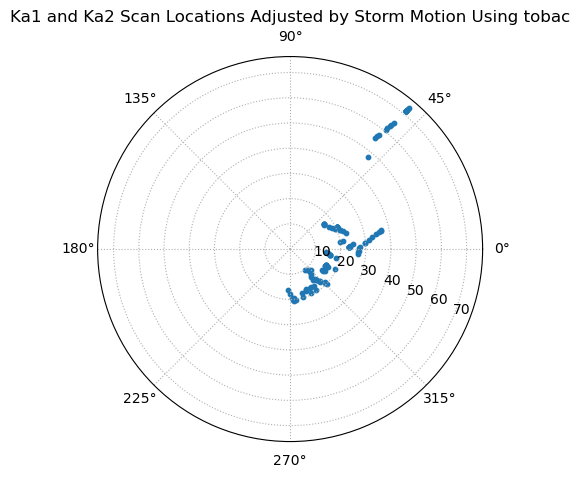

In [101]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 and Ka2 Scan Locations Adjusted by Storm Motion Using tobac")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
#theta = corrected_vads_only_df_ka1.Bearmean[25:35] - np.array(storm_direction_for_ka1_list)[25:35] -90 # adjust for true north in bearing calc being 90
theta = np.array(bearing_storm_ka1_shifted_list) -90
theta_radians = theta * (np.pi/180)
r = distance_ka1_from_storm[0:120]# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

#print(theta_radians)
#print(r)
print(np.shape(theta))
print(np.shape(r))

# theta2 = corrected_vads_only_df_ka2.Bearmean[0:10] - np.array(storm_direction_for_ka2_list)[25:35]- 90
# theta2_radians = theta2 * (np.pi/180)
# r2 = distance_ka2_from_storm[25:35]# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

#print(theta2_radians)
#print(r2)

ka1 = ax.scatter(theta_radians, r, s = 10) # s changes point size
# ka2 = ax.scatter(theta2_radians, r2, s = 10)

# ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()
#rint(storm_direction_for_ka1_list[25:35])

The values above 45 degrees are erroneous, those are the ones taken at 20z when tobac starts at 22z.

(98, 1)
(98,)


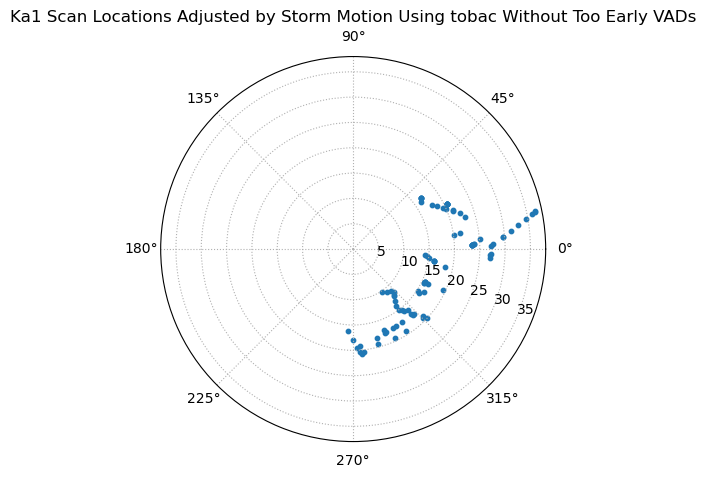

In [102]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 Scan Locations Adjusted by Storm Motion Using tobac Without Too Early VADs")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
#theta = corrected_vads_only_df_ka1.Bearmean[25:35] - np.array(storm_direction_for_ka1_list)[25:35] -90 # adjust for true north in bearing calc being 90
theta = np.array(bearing_storm_ka1_shifted_list)[22:] -90
theta_radians = theta * (np.pi/180)
r = distance_ka1_from_storm[22:120]# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

#print(theta_radians)
#print(r)
print(np.shape(theta))
print(np.shape(r))

# theta2 = corrected_vads_only_df_ka2.Bearmean[0:10] - np.array(storm_direction_for_ka2_list)[25:35]- 90
# theta2_radians = theta2 * (np.pi/180)
# r2 = distance_ka2_from_storm[25:35]# - np.array(ka2_matching_velocity) - np.array(storm_velocity)

#print(theta2_radians)
#print(r2)

ka1 = ax.scatter(theta_radians, r, s = 10) # s changes point size
# ka2 = ax.scatter(theta2_radians, r2, s = 10)

# ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()
#rint(storm_direction_for_ka1_list[25:35])

In [103]:
# FOR KA1
bearing_storm_ka2=[]
tobac_time_array_ka2 = np.array(ka2_vads_df.tobac_time)

for i_2 in range(len(ka2_vads_df.tobac_lats)): # the range of the first tobac time index that is 
                            #closest to the ka1 time and the last tobac time index closest to ka1 time                            
    
    direction2 = get_bearing(ka2_vads_df.tobac_lats[i_2],ka2_vads_df.tobac_lons[i_2],
                            ka2_vads_df.Latmean[i_2], ka2_vads_df.Lonmean[i_2])
    bearing_storm_ka2.append(direction2)
bearing_storm_ka2 = np.append([np.nan],bearing_storm_ka2) # in degrees


bearing_df_2 = pd.DataFrame(bearing_storm_ka2)
bearing_storm_ka2_corrected_df = bearing_df_2.dropna()
bearing_storm_ka2_corrected = np.array(bearing_storm_ka2_corrected_df)

In [104]:
storm_motion_correction_ka2 = 90 - np.array(storm_direction_for_ka2_list)

bearing_storm_ka2_shifted_list = []
for thing_2 in range(len(storm_motion_correction_ka2)):
    bearing_storm_ka2_shifted = bearing_storm_ka2_corrected[thing_2] + storm_motion_correction_ka2[thing_2]
    bearing_storm_ka2_shifted_list.append(bearing_storm_ka2_shifted)

(98, 1)
(98,)


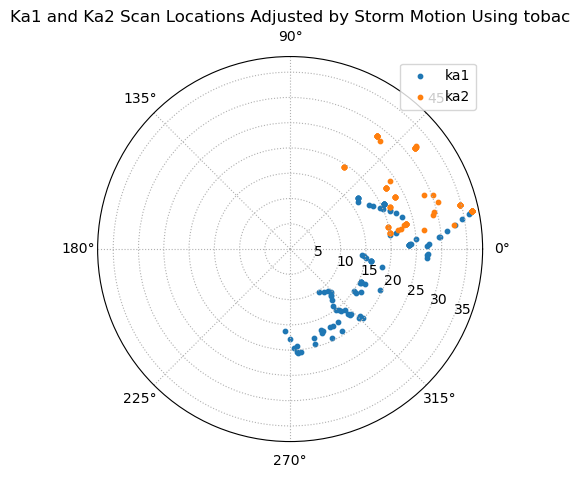

In [105]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Ka1 and Ka2 Scan Locations Adjusted by Storm Motion Using tobac")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
#theta = corrected_vads_only_df_ka1.Bearmean[25:35] - np.array(storm_direction_for_ka1_list)[25:35] -90 # adjust for true north in bearing calc being 90
theta = np.array(bearing_storm_ka1_shifted_list)[22:] -90
theta_radians = theta * (np.pi/180)
r = distance_ka1_from_storm[22:120]# - np.array(ka1_matching_velocity) - np.array(storm_velocity)

#print(theta_radians)
#print(r)
print(np.shape(theta))
print(np.shape(r))

theta2 = np.array(bearing_storm_ka2_shifted_list) -90
theta2_radians = theta2 * (np.pi/180)
r2 = distance_ka2_from_storm[0:101]

#print(theta2_radians)
#print(r2)

ka1 = ax.scatter(theta_radians, r, s = 10) # s changes point size
ka2 = ax.scatter(theta2_radians, r2, s = 10)

ax.legend(['ka1', 'ka2'])
# plt.savefig('/Users/juliabman/Desktop/Seminar_Pictures/both_ka_positions.png')
plt.show()
#rint(storm_direction_for_ka1_list[25:35])

In [ ]:
ka1_r = pd.Series(r)
ka1_theta=pd.Series(theta_radians)
ka1_times = pd.Series(ka1_times_aligning_with_tobac)
ka1_df=pd.DataFrame(pd.concat([ka1_r,ka1_theta, ka1_times],axis=1))
ka1_df.columns=['r','theta','times']
print(np.shape(ka1_df))

#ka1_in_inflow=ka1_df[(ka1_df.r <= 40) & (ka1_df.theta <=90) or (ka1_df.theta > 270)]

ka1_negative_angles=ka1_df[(ka1_df.theta < 0)]
ka1_positive_angles=ka1_df[(ka1_df.theta >= 0)]
#print(ka1_negative_angles)

ka1_in_inflow_negative=ka1_negative_angles[(ka1_negative_angles.theta >= -(np.pi/2)) | (ka1_negative_angles.theta <=-(3 * np.pi)/2) & (ka1_negative_angles.r <=40)]
ka1_in_inflow_positive = ka1_positive_angles[(ka1_positive_angles.theta <= (np.pi/2)) | (ka1_positive_angles.theta >= (3 * np.pi)/2) & (ka1_positive_angles.r <= 40)]

#print(ka1_in_inflow_negative)

#ka1_in_inflow_negative_radians = ka1_in_inflow_negative * (np.pi/180)
#ka1_in_inflow_positive_radians = ka1_in_inflow_positive * (np.pi/180)

#ka1_in_inflow_positive=ka1_positive_angles[(ka1_positive_angles.theta >=270) & (ka1_positive_angles.theta <=90 & (ka1_negative_angles.r <=40)]
#print(ka1_in_inflow)
print(np.shape(ka1_in_inflow_negative))
#print(ka1_in_inflow_negative)
#ka1_in_inflow_df.columns = ['theta', 'r']

In [ ]:
ka2_r = pd.Series(r2)
ka2_theta=pd.Series(theta2_radians)
ka2_times= pd.Series(ka2_times_aligning_with_tobac)
ka2_df=pd.DataFrame(pd.concat([ka2_r,ka2_theta, ka2_times],axis=1))
ka2_df.columns=['r2','theta2','times']
print(np.shape(ka2_df))

#ka1_in_inflow=ka1_df[(ka1_df.r <= 40) & (ka1_df.theta <=90) or (ka1_df.theta > 270)]

ka2_negative_angles=ka2_df[(ka2_df.theta2 < 0)]
ka2_positive_angles=ka2_df[(ka2_df.theta2 >= 0)]
#print(ka2_negative_angles)

#ka2_in_inflow_negative=ka2_negative_angles[(ka2_negative_angles.theta2 >= -90) | (ka2_negative_angles.theta2 <=-270) & (ka2_negative_angles.r2 <=40)]
#ka2_in_inflow_positive = ka2_positive_angles[(ka2_positive_angles.theta2 <= 90) | (ka2_positive_angles.theta2 >= 270) & (ka2_positive_angles.r2 <= 40)]

ka2_in_inflow_negative=ka2_negative_angles[(ka2_negative_angles.theta2 >= -(np.pi/2)) | (ka2_negative_angles.theta2 <=-(3 * np.pi)/2) & (ka2_negative_angles.r2 <=40)]
ka2_in_inflow_positive = ka2_positive_angles[(ka2_positive_angles.theta2 <= (np.pi/2)) | (ka2_positive_angles.theta2 >=(3 * np.pi)/2) & (ka2_positive_angles.r2 <= 40)]

#ka2_in_inflow_negative_radians = ka2_in_inflow_negative * (np.pi/180)
#ka2_in_inflow_positive_radians = ka2_in_inflow_positive * (np.pi/180)
#print(ka2_in_inflow_negative)

#ka1_in_inflow_positive=ka1_positive_angles[(ka1_positive_angles.theta >=270) & (ka1_positive_angles.theta <=90 & (ka1_negative_angles.r <=40)]
#print(ka1_in_inflow)
print(np.shape(ka2_in_inflow_negative))
#ka1_in_inflow_df.columns = ['theta', 'r']